In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import numpy as np # linear algebra
import pandas as pd
import os
import shutil
import random
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [10]:
split=['train','test','val']
labels=['NORMAL', 'PNEUMONIA']

# Source folder containing the files
source_folder = 'C:/Users/HP/Untitled Folder/chest_xray'

# Destination folder to move the files to
destination_folder = 'C:/Users/HP/Final'

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)
    os.makedirs(os.path.join(destination_folder, labels[0]))
    os.makedirs(os.path.join(destination_folder, labels[1]))

for s in tqdm(split):
    for l in labels: 
        sf=os.path.join(source_folder, s)
        sf=os.path.join(sf, l)
        
        df=os.path.join(destination_folder, l)
        
        # Get a list of all files in the source folder
        files = os.listdir(sf)

        # Copy each file from the source folder to the destination folder
        for file_name in files:
            source_file = os.path.join(sf, file_name)
            destination_file = os.path.join(df, file_name)
            if os.path.isfile(source_file):  # Check if the item is a file
                shutil.copy(source_file, destination_file)

print("Files copied to the destination folder.")


100%|██████████| 3/3 [00:13<00:00,  4.40s/it]

Files copied to the destination folder.


In [11]:
folder_path = 'C:/Users/HP/Final/PNEUMONIA'  # Replace this with the path to your folder
file_list = os.listdir(folder_path)

# Shuffle the file list randomly
random.shuffle(file_list)

# Calculate the number of files to delete (half of the total files)
files_to_delete = len(file_list)-len(os.listdir('C:/Users/HP/Final/NORMAL'))

# Delete half of the files
for i in range(files_to_delete):
    file_to_delete = os.path.join(folder_path, file_list[i])
    os.remove(file_to_delete)
#     print(f"Deleted: {file_to_delete}")
print('Deletion complete')

Deletion complete


In [13]:
print(len(os.listdir('C:/Users/HP/Final/NORMAL')))
print(len(os.listdir('C:/Users/HP/Final/PNEUMONIA')))

1583
1583


In [31]:
IMAGE_SIZE = 256 # image resolution
BATCH_SIZE = 32 # since tensorflow work in batches
CHANNELS = 3 # since it is rgb image
EPOCHS = 20

In [32]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/HP/Final", shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3166 files belonging to 2 classes.


In [33]:
class_names = dataset.class_names
class_names

['NORMAL', 'PNEUMONIA']

In [34]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    # test_size = int(test_split * ds_size)

    train_ds=ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)

    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [35]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print(len(train_ds), len(val_ds), len(test_ds))

79 9 11


In [36]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [37]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [38]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [39]:
input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# Load DenseNet121 pre-trained model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Create a new model on top
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(IMAGE_SIZE, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Change the number of neurons based on the classification task

In [40]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [41]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 


Total params: 7300161 (27.85 MB)
Trainable params: 262657 (1.00 MB)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________


In [42]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
79/79 [==============================] - 217s 3s/step - loss: 0.6516 - accuracy: 0.8029 - val_loss: 0.2081 - val_accuracy: 0.9271
Epoch 2/20
79/79 [==============================] - 195s 2s/step - loss: 0.2441 - accuracy: 0.9070 - val_loss: 0.1754 - val_accuracy: 0.9271
Epoch 3/20
79/79 [==============================] - 203s 3s/step - loss: 0.1894 - accuracy: 0.9323 - val_loss: 0.1962 - val_accuracy: 0.9201
Epoch 4/20
79/79 [==============================] - 183s 2s/step - loss: 0.1848 - accuracy: 0.9295 - val_loss: 0.1565 - val_accuracy: 0.9306
Epoch 5/20
79/79 [==============================] - 189s 2s/step - loss: 0.1831 - accuracy: 0.9287 - val_loss: 0.1533 - val_accuracy: 0.9375
Epoch 6/20
79/79 [==============================] - 184s 2s/step - loss: 0.1993 - accuracy: 0.9248 - val_loss: 0.1494 - val_accuracy: 0.9375
Epoch 7/20
79/79 [==============================] - 183s 2s/step - loss: 0.2201 - accuracy: 0.9200 - val_loss: 0.1424 - val_accuracy: 0.9271
Epoch 8/20
79

In [43]:
loss, scores = model.evaluate(test_ds)

11/11 [==============================] - 36s 2s/step - loss: 0.0947 - accuracy: 0.9514


In [44]:
print(f'Test accuracy: {scores * 100:.2f}%')

Test accuracy: 95.14%


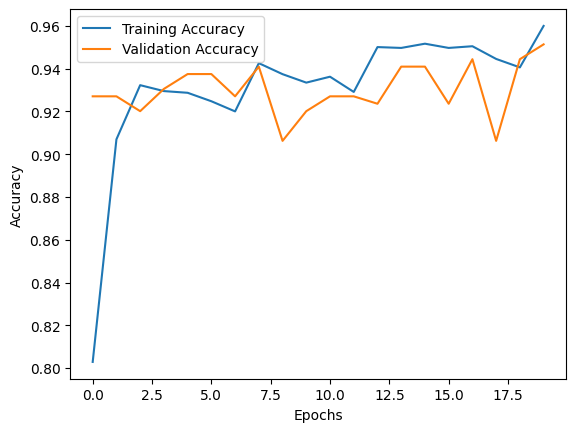

In [45]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [46]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create a batch

    predictions = model.predict(img_array, verbose=0)

    predicted_class_number = round(predictions[0][0])
    predicted_class = class_names[predicted_class_number]
    confidence = round(100*(predictions[0][0]), 2)
    if confidence<50: confidence=100-confidence
    return predicted_class, confidence, predicted_class_number

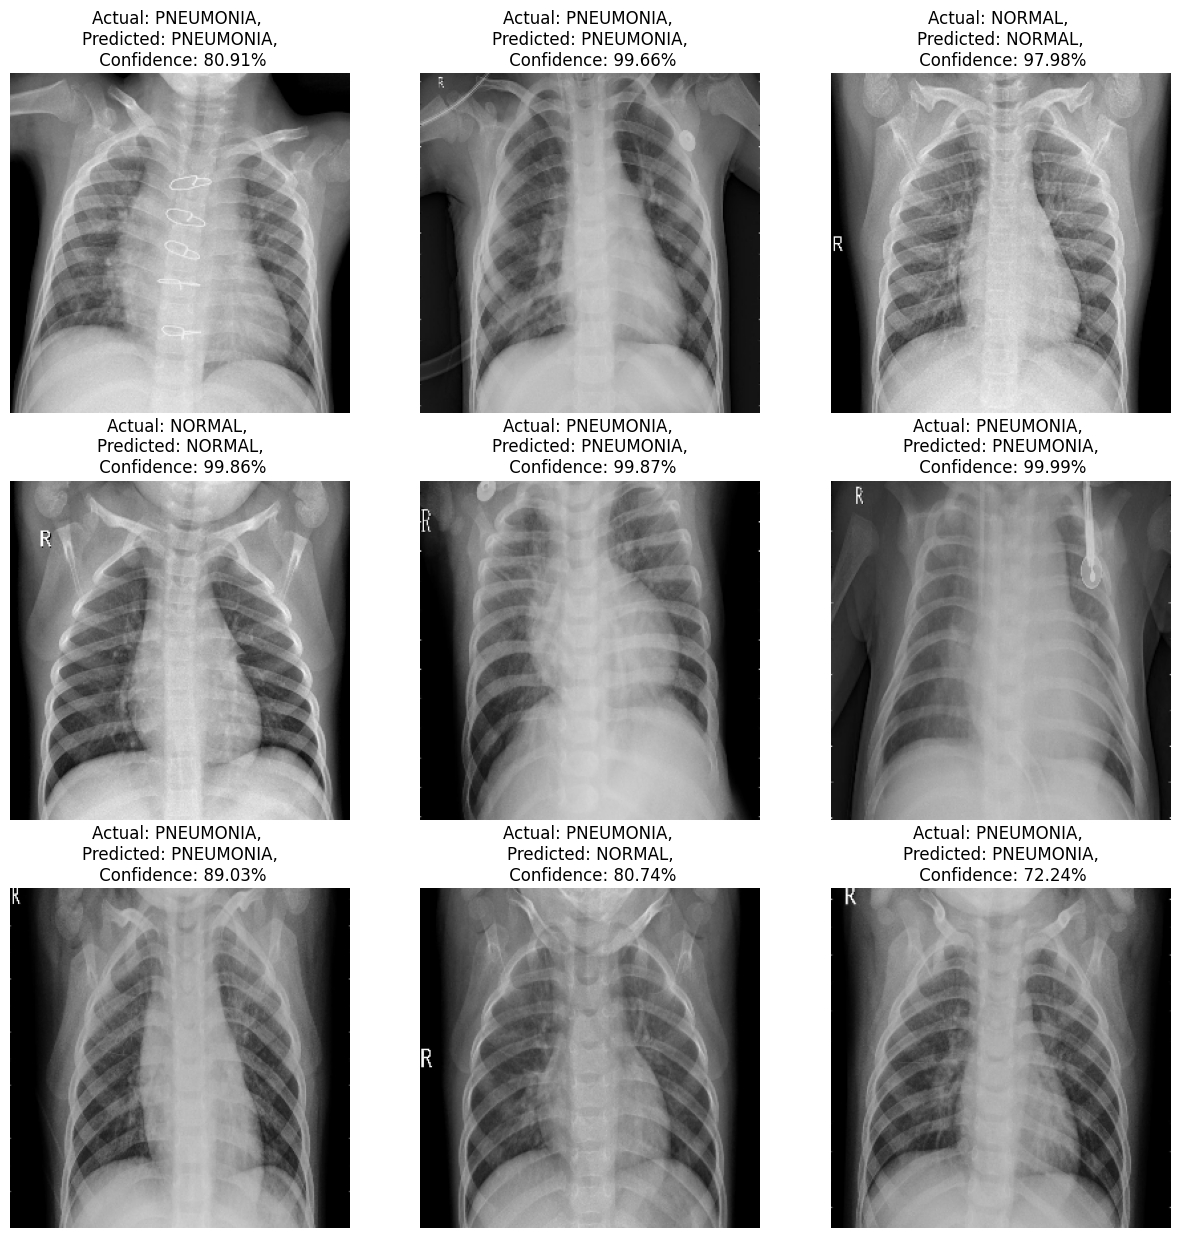

In [47]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence, predicted_class_number = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class},\n Confidence: {confidence}%")
        plt.axis("off")

11/11 [==============================] - 25s 2s/step
Confusion Matrix:
[[169  11]
 [  6 164]]


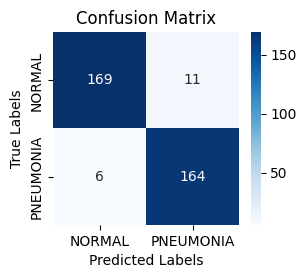

In [48]:
test_images = []
true_labels = []
for images, labels in test_ds:
    test_images.extend(images.numpy())
    true_labels.extend(labels.numpy())

test_images = np.array(test_images)
true_labels = np.array(true_labels)

# Make predictions on the test set
predictions = model.predict(test_images)
predicted_labels = np.rint(predictions)  # Rounding predictions to obtain predicted labels

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(3, 2.5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
